# Initial Conditions & Parameter Exploration for USR in Higgs Inflation

This notebook probes the Ultra-Slow-Roll (USR) dynamics in the Higgs Inflation model, specifically accounting for the dependence on potential parameters $\lambda$ and $\xi$.



## Objectives
1. **Parameter Dependence**: Explore how varying $\xi$ impacts the potential and dynamics.
2. **Initial Conditions Scan**: Systematically scan initial field values $\phi_i$ and velocities $y_i$ to identify USR trajectories.
3. **USR Characterization**: Visualize the evolution of drift parameter $\eta$ to confirm USR signatures ($\eta \approx -6$).

In [12]:
import sys
import os
root_dir = os.path.abspath('..')
if root_dir not in sys.path:
    sys.path.insert(0, root_dir)

import numpy as np
import matplotlib.pyplot as plt
from inflation_models import HiggsModel
from inf_dyn_background import run_background_simulation, get_derived_quantities
from scipy.interpolate import interp1d
import matplotlib.colors as colors

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)

## 1. Effect of Coupling $\xi$ on Potential Scale

First, we check how changing the non-minimal coupling $\xi$ affects the potential scale and background evolution for fixed initial conditions.

xi =  10000 N total =  101.5060973454343
xi =  1000 N total =  448.263836311485
xi =  100 N total =  1022.057678924046


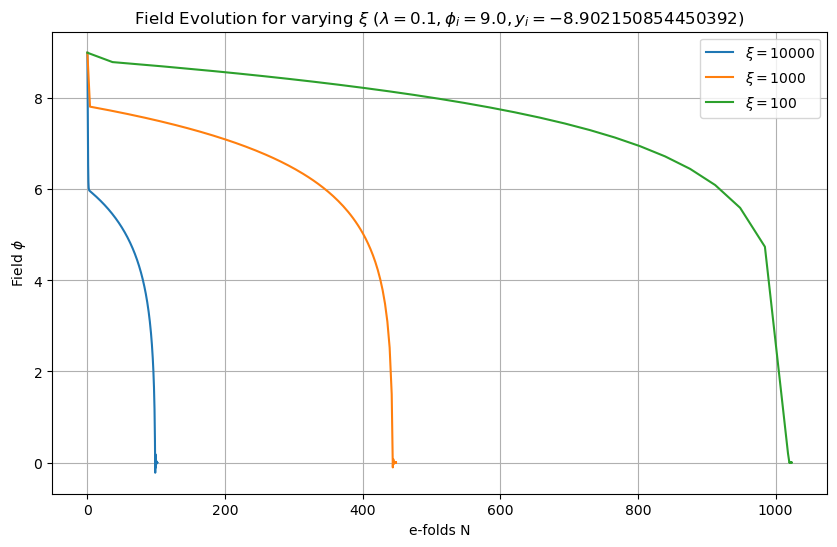

In [13]:
# Fixed Initial Conditions
phi_i = 9.0
y_i = -8.902150854450392

# Vary Xi
xi_values = [10000,1000,100]
lam_val = 0.1

plt.figure(figsize=(10, 6))

for x_val in xi_values:

    model = HiggsModel(lam=lam_val, xi=float(x_val))

    model.phi0 = phi_i
    model.yi = y_i

    T_span = np.linspace(0, 2000, 1000)
    sol = run_background_simulation(model, T_span)
    data = get_derived_quantities(sol, model)

    phi_t = sol[0]
    N_t = data['N']
    eta_t = data['etaH']
    print("xi = ", x_val,"N total = ", N_t[-1])
    
    plt.plot(N_t, phi_t, label=rf'$\xi={x_val}$')

plt.xlabel('e-folds N')
plt.ylabel(r'Field $\phi$')
plt.title(rf'Field Evolution for varying $\xi$ ($\lambda={lam_val}, \phi_i={phi_i}, y_i={y_i}$)')
plt.legend()
plt.grid(True)
plt.show()

## 2. Phase Space Scan for USR

Now we perform a scan over initial velocities $|y_i|$ for a fixed large $\xi=1000$, looking for the Ultra-Slow-Roll phase defined by $\eta \approx -6$.

Scanning 100 velocities for Xi=1000.0...
Scan Complete.
Found max USR duration: 0.23394026534414536


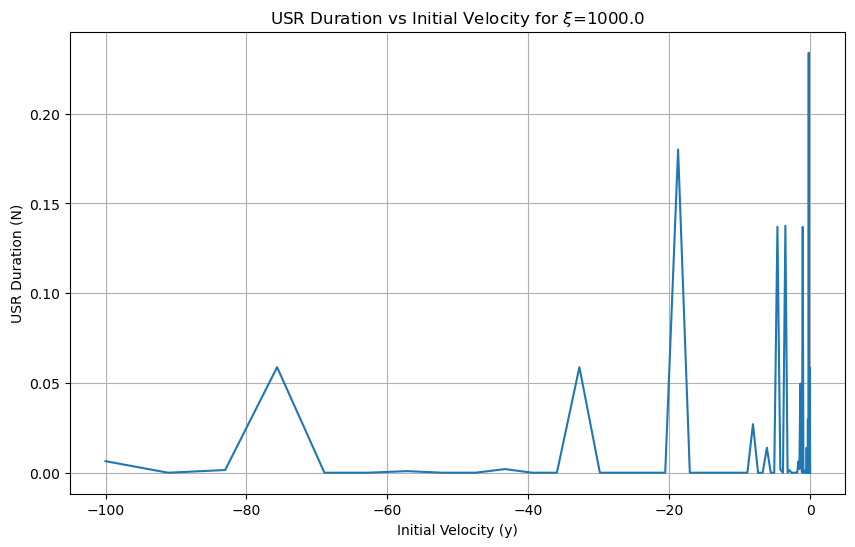

In [11]:
# Model Parameters
model_xi = 1000.0

model_lam = 0.1

# Scan Arrays
phi_fixed = 6 # Starting close to phi_cmb
y_velocities = -np.logspace(-2, 2, 100) # Log spacing from 1e-3 to 1e2

min_etas = []
usr_durations = []

print(f"Scanning {len(y_velocities)} velocities for Xi={model_xi}...")

for y in y_velocities:
    model = HiggsModel(lam=model_lam, xi=model_xi)
    model.phi0 = phi_fixed
    model.yi = y
    
    # Run
    sol = run_background_simulation(model, np.linspace(0, 400, 1000))
    data = get_derived_quantities(sol, model)
    
    # Calculate eta
    eta = 2 * (data['epsH'] - data['etaH'])
 
    
    # Calculate USR duration (N where eta is between -6 +- usr_tol)
    usr_tol = 0.5
    is_usr = (eta > -6 - usr_tol) & (eta < -6 + usr_tol)
    if np.any(is_usr):
        N = data['N']
        # Approximate integral diff
        dN = np.diff(N, prepend=N[0])
        duration = np.sum(dN[is_usr])
        usr_durations.append(duration)
    else:
        usr_durations.append(0.0)

# largest duration
max_duration = np.max(usr_durations)
max_idx = np.argmax(usr_durations)
max_y = y_velocities[max_idx]

print("Scan Complete.")
print("Found max USR duration:", max_duration)

plt.figure(figsize=(10, 6))
plt.plot(y_velocities, usr_durations)
plt.xlabel('Initial Velocity (y)')
plt.ylabel('USR Duration (N)')
plt.title(rf'USR Duration vs Initial Velocity for $\xi$={model_xi}')
plt.grid(True)
plt.show()


## 3. Detailed Trajectory of a USR initial conditions

Let's pick a velocity that yields a significant USR duration (from the plot above) and visualize the full phase space trajectory.

USR Velocity Candidate: -1.261856883066021


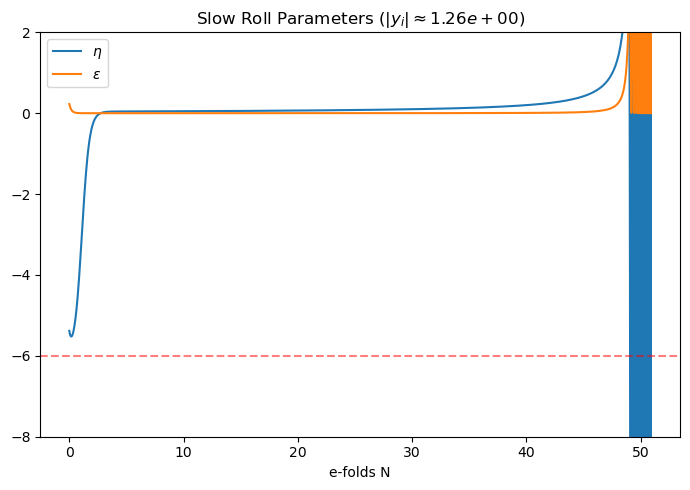

In [7]:
usr_idx = np.argmax(usr_durations)
usr_y = y_velocities[usr_idx]
print(rf"USR Velocity Candidate: {usr_y}")

model = HiggsModel(lam=model_lam, xi=model_xi)
model.phi0 = phi_fixed
model.yi = usr_y

sol = run_background_simulation(model, np.linspace(0, 50, 2000))
data = get_derived_quantities(sol, model)
N = data['N']
eta = 2 * (data['epsH'] - data['etaH'])
eps = data['epsH']

plt.figure(figsize=(7, 5))

plt.plot(N, eta, label=r'$\eta$')
plt.plot(N, eps, label=r'$\epsilon$')
plt.axhline(-6, color='r', linestyle='--', alpha=0.5)
plt.ylim(-8, 2)
plt.xlabel('e-folds N')
plt.legend()
plt.title(rf'Slow Roll Parameters ($|y_i| \approx {abs(usr_y):.2e}$)')


plt.tight_layout()
plt.show()

# Calculate phi at N=60 e-folds

In [14]:
model_params = {'lam': 0.1, 'xi': 1000, 'phi0': 9.0, 'yi': usr_y}

model_plot = HiggsModel(lam=model_params['lam'], xi=model_params['xi'])
model_plot.phi0 = model_params['phi0']
model_plot.yi = model_params['yi']     

print(f"Calculating phi at N=60 for xi={model_params['xi']}, phi_i={model_plot.phi0}...")

# Run simulation
T_sol = np.linspace(0, 30*model_params['xi']/2, 5000)
sol = run_background_simulation(model_plot, T_sol)
data = get_derived_quantities(sol, model_plot)

# Extract Data
N_vals_sim = data['N']
phi_vals_sim = sol[0]
eps_vals = data['epsH']

# Find end of inflation
end_indices = np.where(eps_vals >= 1)[0]

if len(end_indices) > 0:
    idx_end = end_indices[0]
    N_total = N_vals_sim[idx_end]
    N_star_target = N_total - 60.0 
    
    if N_star_target < N_vals_sim[0]:
        print(f"Warning: Total e-folds ({N_total:.2f}) < 60. Using start value.")
        phi_cmb = phi_vals_sim[0]
    else:
        # Interpolate
        interp_phi = interp1d(N_vals_sim[:idx_end], phi_vals_sim[:idx_end], kind='cubic')
        phi_cmb = float(interp_phi(N_star_target))
        print(f"  Inflation Ends @ N={N_total:.2f}")
        print(f"  CMB Horizon Exit @ N={N_star_target:.2f} -> phi_cmb={phi_cmb:.4f}")
else:
    print("Warning: Inflation did not end in simulation time. Using default.")


Calculating phi at N=60 for xi=1000, phi_i=9.0...
  Inflation Ends @ N=964.33
  CMB Horizon Exit @ N=904.33 -> phi_cmb=5.4203


In [16]:
target_xi = 1000.0
model_params = {'lam': 0.1, 'xi': target_xi, 'phi0': 9.0, 'yi': usr_y}

model_plot = HiggsModel(lam=model_params['lam'], xi=model_params['xi'])
model_plot.phi0 = model_params['phi0']
model_plot.yi = model_params['yi']     

T_max = max(200.0, 2.0 * model_params['xi']) 

num_points = int(T_max * 2.0) 
num_points = max(num_points, 2000)

print(f"Calculating phi at N=60 for xi={model_params['xi']}...")
print(f"Using T_max={T_max}, num_points={num_points}")

T_sol = np.linspace(0, T_max, num_points)
sol = run_background_simulation(model_plot, T_sol)
data = get_derived_quantities(sol, model_plot)

N_vals_sim = data['N']
phi_vals_sim = sol[0]
eps_vals = data['epsH']

crossings = np.where((eps_vals[:-1] < 1.0) & (eps_vals[1:] >= 1.0))[0]

if len(crossings) > 0:
    idx_end = crossings[0]
    N_total = N_vals_sim[idx_end]
    N_star_target = N_total - 60.0 
    
    if N_star_target < N_vals_sim[0]:
        print(f"Warning: Total e-folds ({N_total:.2f}) < 60. Using start value.")
    else:
        interp_phi = interp1d(N_vals_sim[:idx_end+2], phi_vals_sim[:idx_end+2], kind='cubic')
        phi_cmb = float(interp_phi(N_star_target))
        print(f"  Inflation Ends @ N={N_total:.4f}")
        print(f"  CMB Horizon Exit @ N={N_star_target:.4f} -> phi_cmb={phi_cmb:.4f}")
else:
    print("Warning: Inflation did not end in simulation time.")

Calculating phi at N=60 for xi=1000.0...
Using T_max=2000.0, num_points=4000
  Inflation Ends @ N=963.9026
  CMB Horizon Exit @ N=903.9026 -> phi_cmb=5.4286


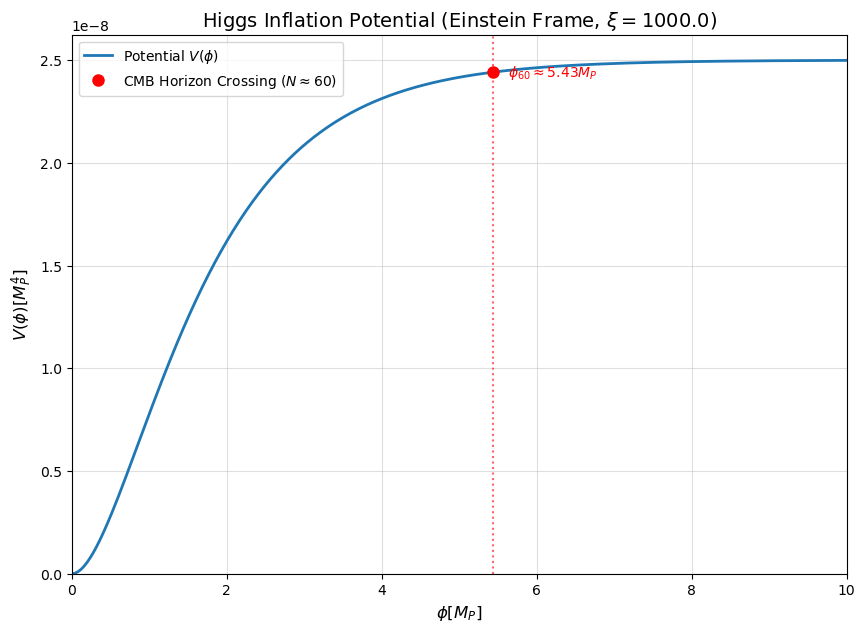

In [17]:
V_cmb = model_plot.v0 * model_plot.f(phi_cmb)

phi_arr = np.linspace(0, 10, 500)
V_arr = model_plot.v0 * model_plot.f(phi_arr)

plt.figure(figsize=(10, 7))
plt.plot(phi_arr, V_arr, linewidth=2, label=r'Potential $V(\phi)$')

# CMB Marker
plt.plot(phi_cmb, V_cmb, 'ro', markersize=8, label=r'CMB Horizon Crossing ($N \approx 60$)')
plt.axvline(x=phi_cmb, color='r', linestyle=':', alpha=0.6)
plt.text(phi_cmb + 0.2, V_cmb, rf'$\phi_{{60}} \approx {phi_cmb:.2f} M_P$', 
         color='r', verticalalignment='center')

plt.title(rf'Higgs Inflation Potential (Einstein Frame, $\xi = {model_params["xi"]}$)', fontsize=14)
plt.xlabel(r'$\phi [M_P]$', fontsize=12)
plt.ylabel(r'$V(\phi) [M_P^4]$', fontsize=12)
plt.xlim(0, 10)
plt.ylim(0, np.max(V_arr) * 1.05)
plt.grid(True, alpha=0.4)
plt.legend(loc='upper left', fontsize=10)

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.show()

Scanning 20 values of xi for phi_cmb...
xi=10.0: OK. phi_60=5.4275
xi=14.4: OK. phi_60=5.4484
xi=20.7: OK. phi_60=5.4079
xi=29.8: OK. phi_60=5.4151
xi=42.8: OK. phi_60=5.4458
xi=61.6: OK. phi_60=5.4470
xi=88.6: OK. phi_60=5.4350
xi=127.4: OK. phi_60=5.4327
xi=183.3: OK. phi_60=5.4347
xi=263.7: OK. phi_60=5.4424
xi=379.3: OK. phi_60=5.4350
xi=545.6: OK. phi_60=5.4326
xi=784.8: OK. phi_60=5.4298
xi=1128.8: OK. phi_60=5.4270
xi=1623.8: OK. phi_60=5.4243
xi=2335.7: OK. phi_60=5.4269
xi=3359.8: OK. phi_60=5.4237
xi=4832.9: OK. phi_60=5.4249
xi=6951.9: OK. phi_60=5.4246
xi=10000.0: OK. phi_60=5.4239
Found 20 valid points.


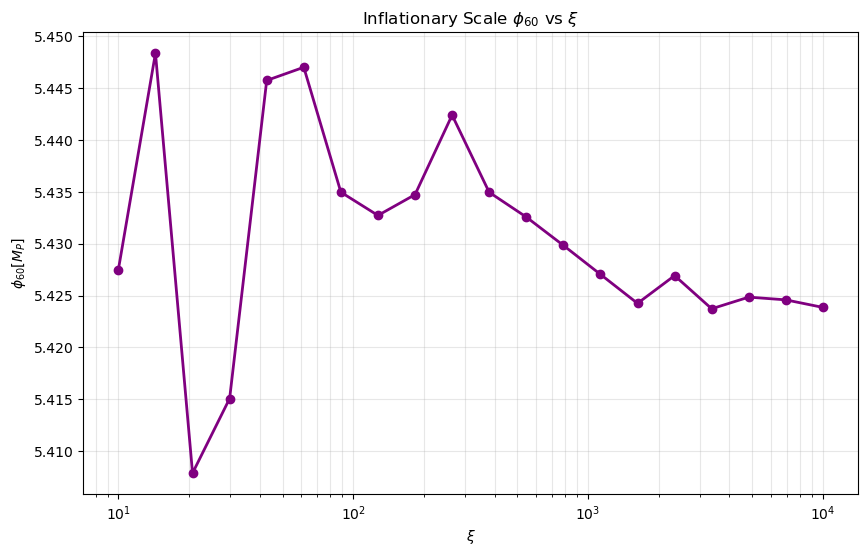

<Figure size 1000x600 with 0 Axes>

In [ ]:
xi_scan_values = np.logspace(1, 4, 20) 

phi_60_results = []
valid_xis = []

save_dir = os.path.join("..", "plots")

print(f"Scanning {len(xi_scan_values)} values of xi for phi_cmb...")

for xi_val in xi_scan_values:
    model_scan = HiggsModel(lam=0.1, xi=xi_val)
    
    # Initial Conditions
    model_scan.phi0 = 9.0  
    model_scan.yi = usr_y

    # Time Scaling
    # We found T ~ xi is needed.
    # We give it plenty of room: T = 2.0 * xi.
    T_max = max(200.0, 2.0 * xi_val) 
    
    # Resolution Scaling
    # Ensure dt is small enough to catch the end of inflation
    # dt = 0.5 is usually fine for slow roll, but maybe smaller near end.
    num_points = int(T_max * 2.0) # dt = 0.5
    num_points = max(num_points, 2000)
    
    T_scan = np.linspace(0, T_max, num_points)
    
    # Run Simulation with Error Handling
    try:
        sol_scan = run_background_simulation(model_scan, T_scan)
        
        # Determine if valid (check for NaNs)
        if np.any(np.isnan(sol_scan)):
            print(f"xi={xi_val:.1f}: Simulation returned NaNs.")
            continue
            
        data_scan = get_derived_quantities(sol_scan, model_scan)

        N_vals = data_scan['N']
        phi_vals = sol_scan[0]
        eps_vals = data_scan['epsH']
        
        # Find end of inflation
        # Use a more robust check than just eps >= 1 in case of noise
        # We look for the first time eps crosses 1 from below
        
        crossings = np.where((eps_vals[:-1] < 1.0) & (eps_vals[1:] >= 1.0))[0]
        
        if len(crossings) > 0:
            idx_end = crossings[0]
            N_total = N_vals[idx_end]
            
            N_star = N_total - 60.0
            
            if N_star >= N_vals[0]:
                interp_func = interp1d(N_vals[:idx_end+2], phi_vals[:idx_end+2], kind='cubic')
                phi_60 = float(interp_func(N_star))
                phi_60_results.append(phi_60)
                valid_xis.append(xi_val)
                print(f"xi={xi_val:.1f}: OK. phi_60={phi_60:.4f}")
            else:
                print(f"xi={xi_val:.1f}: Total N={N_total:.1f} ( < 60 )")
        else:
            # If no crossing, maybe it ended efficiently at the very last step?
            if eps_vals[-1] > 1:
                # It ended
                N_total = N_vals[-1]
                if N_total > 60:
                     # Fallback interpolation
                     interp_func = interp1d(N_vals, phi_vals, kind='cubic')
                     phi_60 = float(interp_func(N_total-60.0))
                     phi_60_results.append(phi_60)
                     valid_xis.append(xi_val)
                     print(f"xi={xi_val:.1f}: OK (Boundary). phi_60={phi_60:.4f}")
            else:
                print(f"xi={xi_val:.1f}: Inflation did not end. Max eps={np.max(eps_vals):.2f}")
                
    except Exception as e:
        print(f"xi={xi_val:.1f}: Error during execution -> {e}")

print(f"Found {len(valid_xis)} valid points.")

plt.figure(figsize=(10, 6))
plt.semilogx(valid_xis, phi_60_results, 'o-', color='purple', linewidth=2, label=r'$\phi_{60}$')
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\phi_{60} [M_P]$')
plt.title(r'Inflationary Scale $\phi_{60}$ vs $\xi$')
plt.grid(True, which="both", alpha=0.3)
plt.show()
plt.savefig(os.path.join(save_dir, "phi_60_vs_xi.png"), dpi=300)